# Monte-Carlo Cardinality Estimation with ORIGAMI

We have a discrete factorised probability distribution of the form:
$$
f(\mathbf{x}) = f(x_1)\cdot f(x_2 | x_1)\cdot \ldots \cdot f(x_n | x_{<n})
$$
We are interested in a sum $S = \sum_{x \in E} f(\mathbf{x})$ over all $x$ from a subset $E$ (a query region), as this represents the probability of seeing data in region $E$ (which equates to cardinality estimation of a query represented by region $E$).

It is usually intractable to enumerate all elements $x \in E$ completely, especially in higher-dimensional spaces and with continuous (or high cardinality) fields. 

However, we can use Monte Carlo Sampling to approximate the sum $S$.

### Monte-Carlo Method

We begin with the base case, showing how $S$ can be approximated with Monte-Carlo. 

We define a Random Variable $X$ in the context of a probability space with:
- $\Omega = E$, the query region
- a $\sigma$-algebra $\mathcal{F}$ as the power set $\mathcal{P}(\Omega)$
- a uniform probability distribution $P : \Omega \rightarrow [0, 1] = \mathrm{Unif}(E)$ distributed over $E$, with $p(x) = \frac{1}{|E|}$ for all x. We choose the uniform distribution to make the expectations below easier to work with (stuff cancels out).

The random variable is defined as $X = f(\mathbf x)$.

The expectation of $X$ is:

$$
\mathbb{E}[X] = \sum_{x \in E} f(x) \cdot p(x) = \frac{1}{|E|} \sum_{x \in E} f(x) 
$$

This is very close to the sum $S$ we want to approximate (see above), apart from the fraction $\frac{1}{|E|}$. Therefore, we can express $S$ as:

$$
S = \sum_{x \in E} f(x) = |E|\cdot \mathbb{E}[X]
$$

With Monte Carlo, we can now approximate the expectation term, and get an estimator for $S$:
$$
\hat{S}_{MC} = |E| \cdot \frac{1}{N} \sum_{i=1}^N f(x^{(j)}) 
$$
where we draw $N$ samples $x^{(j)}$ i.i.d. from our probability distribution $P$ uniformly, i.e. choosing each $x^{(j)}$ with equal probability (we do not sample from the learned model distribution $f$ here).

To calculate $|E| = |E_1| \cdot |E_2| \ldots |E_n|$, we determine $|E_i|$ as the number of discrete values (for numeric fields, the number of bins) for field $i$ that fall within the query range for that field. This gives us the total number of discrete states (bin combinations) in the query region $E$. Evaluating $f(\mathbf x)$ is also efficient and can be done in a single forward pass as a point estimate.

## Create 2D Gaussian Dataset

In [1]:
# Generate 2D data with gaussian distribution
from copy import deepcopy
from pprint import pprint

import numpy as np
import pandas as pd

NUM_DOCS = 20000

# Create a Pandas dataframe with documents of a and b fields following a 2D Gaussian distribution
df = pd.DataFrame()
mean = [4, -2]

# Skewed covariance matrix to make the data correlated
cov = [[1.0, 0.6], [0.8, 0.3]]

a, b = np.random.multivariate_normal(mean, cov, NUM_DOCS).T
docs = [{"a": float(x), "b": float(y)} for x, y in zip(a, b)]
df["docs"] = deepcopy(docs)

pprint(docs[:3])
df.head()

[{'a': 4.063456444942843, 'b': -1.2981219766501042},
 {'a': 3.8698872034531266, 'b': -1.7954389825424724},
 {'a': 4.0170644012679535, 'b': -1.417871963452327}]


/var/folders/cp/r86_5xy15c564s3wsczlqgrc0000gn/T/ipykernel_14056/1554998531.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  a, b = np.random.multivariate_normal(mean, cov, NUM_DOCS).T


,docs
0,"{'a': 4.063456444942843, 'b': -1.2981219766501..."
1,"{'a': 3.8698872034531266, 'b': -1.795438982542..."
2,"{'a': 4.0170644012679535, 'b': -1.417871963452..."
3,"{'a': 0.7306061249542477, 'b': -4.0163608596469}"
4,"{'a': 3.1200371954032287, 'b': -3.144713997233..."


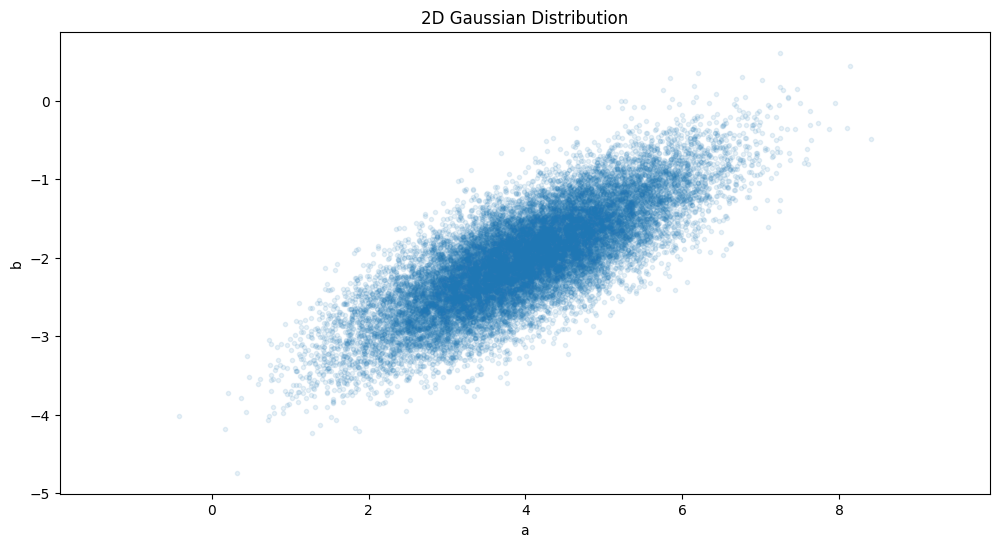

In [2]:
# Plot the data in a 2d scatter plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter([doc["a"] for doc in df["docs"]], [doc["b"] for doc in df["docs"]], marker=".", alpha=0.1)

plt.title("2D Gaussian Distribution")
plt.xlabel("a")
plt.ylabel("b")
plt.axis("equal")
plt.show()

## Set up the Data Processing Pipeline

In [3]:
from sklearn.pipeline import Pipeline

from origami.preprocessing import (
    DocTokenizerPipe,
    KBinsDiscretizerPipe,
    PadTruncTokensPipe,
    SchemaParserPipe,
    TokenEncoderPipe,
    # load_df_from_mongodb,   use this if loading data from mongodb
)
from origami.utils import set_seed

# For reproducibility
set_seed(123)

# Here we use the generated 2D gaussian DataFrame as an example
# But this could be replaced with a call to load_df_from_mongodb
# df = load_df_from_mongodb(...)

NUM_BINS = 100
STRATEGY = "uniform"

# Create data pipeline (we don't use the build_prediction_pipelines() utility here because we need to set custom binning parameters)
pipeline = Pipeline(
    [
        ("binning", KBinsDiscretizerPipe(bins=NUM_BINS, strategy=STRATEGY)),
        ("schema", SchemaParserPipe()),
        # No upscaler or permuter, it's not needed for MC estimation
        ("tokenizer", DocTokenizerPipe()),
        ("padding", PadTruncTokensPipe(length="max")),
        ("encoder", TokenEncoderPipe()),
    ],
)

# Process data
processed_df = pipeline.fit_transform(df).reset_index(drop=True)

# Get stateful objects
schema = pipeline["schema"].schema
encoder = pipeline["encoder"].encoder
block_size = pipeline["padding"].length

# Print data stats
print(f"len train: {len(processed_df)}")
print(f"vocab size {encoder.vocab_size}")
print(f"block size {block_size}")

len train: 20000
vocab size 194
block size 7


In [4]:
processed_df.head()

,docs,tokens
0,"{'a': 4.03617322891958, 'b': -1.287828058302142}","[1, 10, 11, 12, 13, 2, 0]"
1,"{'a': 3.8597963845116277, 'b': -1.769709805576...","[1, 10, 14, 12, 15, 2, 0]"
2,"{'a': 4.03617322891958, 'b': -1.3949128910298352}","[1, 10, 11, 12, 16, 2, 0]"
3,"{'a': 0.7732016073724582, 'b': -4.018491292858...","[1, 10, 17, 12, 18, 2, 0]"
4,"{'a': 3.1542890068798175, 'b': -3.161812631036...","[1, 10, 19, 12, 20, 2, 0]"


## Train ORiGAMi Model

Here we instantiate an ORiGAMi model, a modified transformer trained on the token sequences created above.
We use a standard "medium" configuration. ORiGAMi models are relatively robust to the choice of hyper-parameter
and default configurations often work well for mid-sized datasets.

In [5]:
from origami.model import ORIGAMI
from origami.model.vpda import ObjectVPDA
from origami.preprocessing import DFDataset
from origami.utils import ModelConfig, TrainConfig, count_parameters

# Model and train configs
model_config = ModelConfig.from_preset("medium")  # "small" also works, see origami/utils/config.py for more presets
model_config.position_encoding = "KEY_VALUE"
model_config.vocab_size = encoder.vocab_size
model_config.block_size = block_size

train_config = TrainConfig()
train_config.learning_rate = 5e-4
train_config.print_every = 100

# Wrap dataframe in datasets
dataset = DFDataset(processed_df)

# Create PDA and pass it to the model
vpda = ObjectVPDA(encoder, schema)
model = ORIGAMI(model_config, train_config, vpda=vpda)

n_params = count_parameters(model)
print(f"Number of parameters: {n_params / 1e6:.2f}M")

Number of parameters: 2.74M


In [6]:
from origami.utils import make_progress_callback

# Create and register progress callback
progress_callback = make_progress_callback(train_config, train_dataset=dataset)
model.set_callback("on_batch_end", progress_callback)
model.train_model(dataset, batches=5000)

|  step: 0  |  epoch: 0  |  batch_num: 0  |  batch_dt: 0.00  |  batch_loss: 2.6309  |  lr: 5.05e-07  |
|  step: 1  |  epoch: 0  |  batch_num: 100  |  batch_dt: 38.12  |  batch_loss: 1.6900  |  lr: 5.05e-05  |
|  step: 2  |  epoch: 1  |  batch_num: 200  |  batch_dt: 37.55  |  batch_loss: 1.6037  |  lr: 1.01e-04  |
|  step: 3  |  epoch: 1  |  batch_num: 300  |  batch_dt: 37.38  |  batch_loss: 1.5998  |  lr: 1.51e-04  |
|  step: 4  |  epoch: 2  |  batch_num: 400  |  batch_dt: 37.48  |  batch_loss: 1.4973  |  lr: 2.01e-04  |
|  step: 5  |  epoch: 2  |  batch_num: 500  |  batch_dt: 36.64  |  batch_loss: 1.4924  |  lr: 2.51e-04  |
|  step: 6  |  epoch: 3  |  batch_num: 600  |  batch_dt: 37.10  |  batch_loss: 1.5047  |  lr: 3.01e-04  |
|  step: 7  |  epoch: 3  |  batch_num: 700  |  batch_dt: 37.25  |  batch_loss: 1.4757  |  lr: 3.51e-04  |
|  step: 8  |  epoch: 4  |  batch_num: 800  |  batch_dt: 37.84  |  batch_loss: 1.4607  |  lr: 4.01e-04  |
|  step: 9  |  epoch: 4  |  batch_num: 900  |  ba

In [7]:
# Load/save model
# model.load("origami_gauss_checkpoint.pt")
# model.save("origami_gauss_checkpoint.pt")

## Monte-Carlo Cardinality Estimation

Now we use the `MCEstimator` class to perform cardinality estimation on queries.

### Single Query Example

Let's start with a single query to see how the estimator works.

In [8]:
from mdbrtools.query import parse_from_mql

from origami.inference import MCEstimator
from origami.utils import compare_estimate_to_ground_truth

# Create the Monte Carlo estimator
estimator = MCEstimator(model, pipeline)

# Define a query
query_dict = {"a": {"$gte": 1, "$lte": 3}, "b": {"$gte": -3, "$lte": -2}}
query = parse_from_mql(query_dict)

# Get estimate (returns selectivity/probability)
p, samples = estimator.estimate(query, n=1000)

# Compare to ground truth
result = compare_estimate_to_ground_truth(query, docs, p)

# Print results
print(f"Query: {query_dict}")
print()
print(f"Ground Truth Count:       {result['ground_truth_count']}")
print(f"Estimated Count:          {result['estimated_count']:.1f}")
print()
print(
    f"Ground Truth Selectivity: {result['ground_truth_selectivity']:.4f} ({result['ground_truth_selectivity'] * 100:.2f}%)"
)
print(f"Estimated Selectivity:    {result['estimated_selectivity']:.4f} ({result['estimated_selectivity'] * 100:.2f}%)")
print()
print(f"Q-Error:                  {result['q_error']:.2f}x")
print(f"Relative Error:           {result['relative_error']:.2%}")

Query: {'a': {'$gte': 1, '$lte': 3}, 'b': {'$gte': -3, '$lte': -2}}

Ground Truth Count:       2406
Estimated Count:          2371.7

Ground Truth Selectivity: 0.1203 (12.03%)
Estimated Selectivity:    0.1186 (11.86%)

Q-Error:                  1.01x
Relative Error:           1.42%


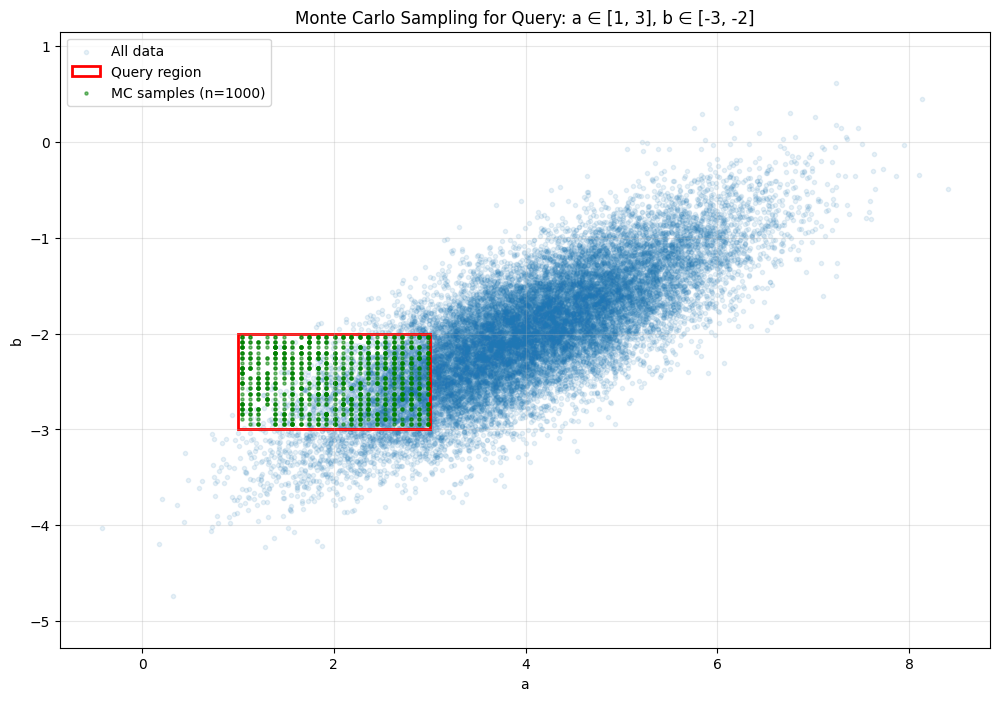

Verification: 1000/1000 samples are inside the query region


In [17]:
# Visualize the query region and generated samples
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Plot all data points in gray
plt.scatter([doc["a"] for doc in docs], [doc["b"] for doc in docs], marker=".", alpha=0.1, label="All data")

# Extract query bounds from the query dict
a_min, a_max = query_dict["a"]["$gte"], query_dict["a"]["$lte"]
b_min, b_max = query_dict["b"]["$gte"], query_dict["b"]["$lte"]

# Draw red rectangle for query region
rect = patches.Rectangle(
    (a_min, b_min), a_max - a_min, b_max - b_min, linewidth=2, edgecolor="red", facecolor="none", label="Query region"
)
ax.add_patch(rect)

# Plot generated MC samples in green
sample_a = [s["a"] for s in samples]
sample_b = [s["b"] for s in samples]
plt.scatter(sample_a, sample_b, marker=".", alpha=0.5, c="green", s=20, label=f"MC samples (n={len(samples)})")

plt.title(f"Monte Carlo Sampling for Query: a ∈ [{a_min}, {a_max}], b ∈ [{b_min}, {b_max}]")
plt.xlabel("a")
plt.ylabel("b")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis("equal")
plt.show()

# Print verification
samples_in_region = sum(1 for s in samples if a_min <= s["a"] <= a_max and b_min <= s["b"] <= b_max)
print(f"Verification: {samples_in_region}/{len(samples)} samples are inside the query region")


### Evaluate Estimator Across Multiple Random Queries

Now let's evaluate how well the Monte Carlo estimator works across many different random query ranges.

In [10]:
# Helper function to generate random query ranges
def generate_random_query_range(
    data_min: float,
    data_max: float,
    min_fraction: float = 0.05,
    max_fraction: float = 0.5,
) -> tuple[float, float]:
    """Generate a random query range within the data bounds.

    Args:
        data_min: Minimum value in the data
        data_max: Maximum value in the data
        min_fraction: Minimum fraction of the full range (default 5%)
        max_fraction: Maximum fraction of the full range (default 50%)

    Returns:
        (range_min, range_max): The query range bounds
    """
    full_range = data_max - data_min

    # Random range size between min_fraction and max_fraction of full range
    range_size = np.random.uniform(min_fraction * full_range, max_fraction * full_range)

    # Random starting point ensuring the range fits within data bounds
    max_start = data_max - range_size
    range_min = np.random.uniform(data_min, max_start)
    range_max = range_min + range_size

    return range_min, range_max

In [ ]:
def evaluate_multiple_queries(n_queries: int = 10, num_samples: int = 1000, seed: int = None) -> pd.DataFrame:
    """Evaluate the Monte Carlo cardinality estimator on multiple random query ranges.

    Args:
        n_queries: Number of random queries to evaluate
        num_samples: Number of uniform samples per query
        seed: Random seed for reproducibility

    Returns:
        DataFrame with results for each query
    """
    if seed is not None:
        np.random.seed(seed)

    # Get the actual data ranges from the original dataset
    a_values = [doc["a"] for doc in docs]
    b_values = [doc["b"] for doc in docs]

    data_a_min, data_a_max = min(a_values), max(a_values)
    data_b_min, data_b_max = min(b_values), max(b_values)

    print(f"Data ranges: a ∈ [{data_a_min:.2f}, {data_a_max:.2f}], b ∈ [{data_b_min:.2f}, {data_b_max:.2f}]")
    print(f"Evaluating {n_queries} random queries with {num_samples} samples each...")
    print()

    results = []

    for i in range(n_queries):
        # Generate random query ranges (5-50% of data range)
        a_min, a_max = generate_random_query_range(data_a_min, data_a_max)
        b_min, b_max = generate_random_query_range(data_b_min, data_b_max)

        print(f"Query {i + 1}/{n_queries}: a ∈ [{a_min:.2f}, {a_max:.2f}], b ∈ [{b_min:.2f}, {b_max:.2f}]", end=" --- ")

        # Create query and estimate
        query_dict = {"a": {"$gte": a_min, "$lte": a_max}, "b": {"$gte": b_min, "$lte": b_max}}
        query = parse_from_mql(query_dict)
        p, _ = estimator.estimate(query, n=num_samples)

        # Compare to ground truth
        result = compare_estimate_to_ground_truth(query, docs, p)
        result["query_id"] = i + 1
        result["query"] = query_dict
        results.append(result)

        print(
            f"GT: {result['ground_truth_count']}, Est: {result['estimated_count']:.1f}, "
            f"Q-Error: {result['q_error']:.2f}x, "
            f"Selectivity: {result['ground_truth_selectivity']:.2%}"
        )

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Print summary statistics
    print("=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    print(f"Mean Q-Error:             {results_df['q_error'].mean():.2f}x")
    print(f"Median Q-Error:           {results_df['q_error'].median():.2f}x")
    print(f"Min Q-Error:              {results_df['q_error'].min():.2f}x")
    print(f"95th percentile Q-Error:  {results_df['q_error'].quantile(0.95):.2f}x")
    print(f"99th percentile Q-Error:  {results_df['q_error'].quantile(0.99):.2f}x")
    print(f"Max Q-Error:              {results_df['q_error'].max():.2f}x")
    print(f"Mean selectivity:         {results_df['ground_truth_selectivity'].mean():.2%}")

    return results_df

In [12]:
# Run evaluation on 100 random queries with 1000 samples each
results_df = evaluate_multiple_queries(n_queries=100, num_samples=1000, seed=42)

Data ranges: a ∈ [-0.42, 8.40], b ∈ [-4.74, 0.61]
Evaluating 100 random queries with 1000 samples each...

Query 1/100: a ∈ [6.13, 8.06], b ∈ [-2.75, -0.72] --- GT: 291, Est: 286.9, Q-Error: 1.01x, Selectivity: 1.46%
Query 2/100: a ∈ [1.61, 4.17], b ∈ [-1.87, -0.80] --- GT: 1939, Est: 1606.9, Q-Error: 1.21x, Selectivity: 9.70%
Query 3/100: a ∈ [5.45, 5.93], b ∈ [-3.54, -0.93] --- GT: 847, Est: 933.7, Q-Error: 1.10x, Selectivity: 4.23%
Query 4/100: a ∈ [2.02, 5.64], b ∈ [-0.69, 0.60] --- GT: 110, Est: 79.2, Q-Error: 1.39x, Selectivity: 0.55%
Query 5/100: a ∈ [4.26, 8.20], b ∈ [-1.42, -0.69] --- GT: 2909, Est: 2808.8, Q-Error: 1.04x, Selectivity: 14.54%
Query 6/100: a ∈ [4.34, 6.72], b ∈ [-2.86, -0.51] --- GT: 7230, Est: 7498.8, Q-Error: 1.04x, Selectivity: 36.15%
Query 7/100: a ∈ [3.32, 6.62], b ∈ [-1.75, -0.22] --- GT: 6611, Est: 6781.6, Q-Error: 1.03x, Selectivity: 33.05%
Query 8/100: a ∈ [6.05, 7.37], b ∈ [-3.38, -1.32] --- GT: 66, Est: 74.8, Q-Error: 1.14x, Selectivity: 0.33%
Query 

In [13]:
# Display the results
results_df[["query_id", "ground_truth_count", "estimated_count", "q_error", "ground_truth_selectivity"]]

,query_id,ground_truth_count,estimated_count,q_error,ground_truth_selectivity
0,1,291,286.925460,1.013937,0.01455
1,2,1939,1606.887265,1.206596,0.09695
2,3,847,933.656094,1.102715,0.04235
3,4,110,79.226784,1.392405,0.00550
4,5,2909,2808.770848,1.035600,0.14545
...,...,...,...,...,...
95,96,1362,1251.065770,1.088729,0.06810
96,97,69,40.063081,1.725000,0.00345
97,98,43,37.224558,1.162162,0.00215
98,99,1064,1182.542452,1.111842,0.05320


## Visualize Results

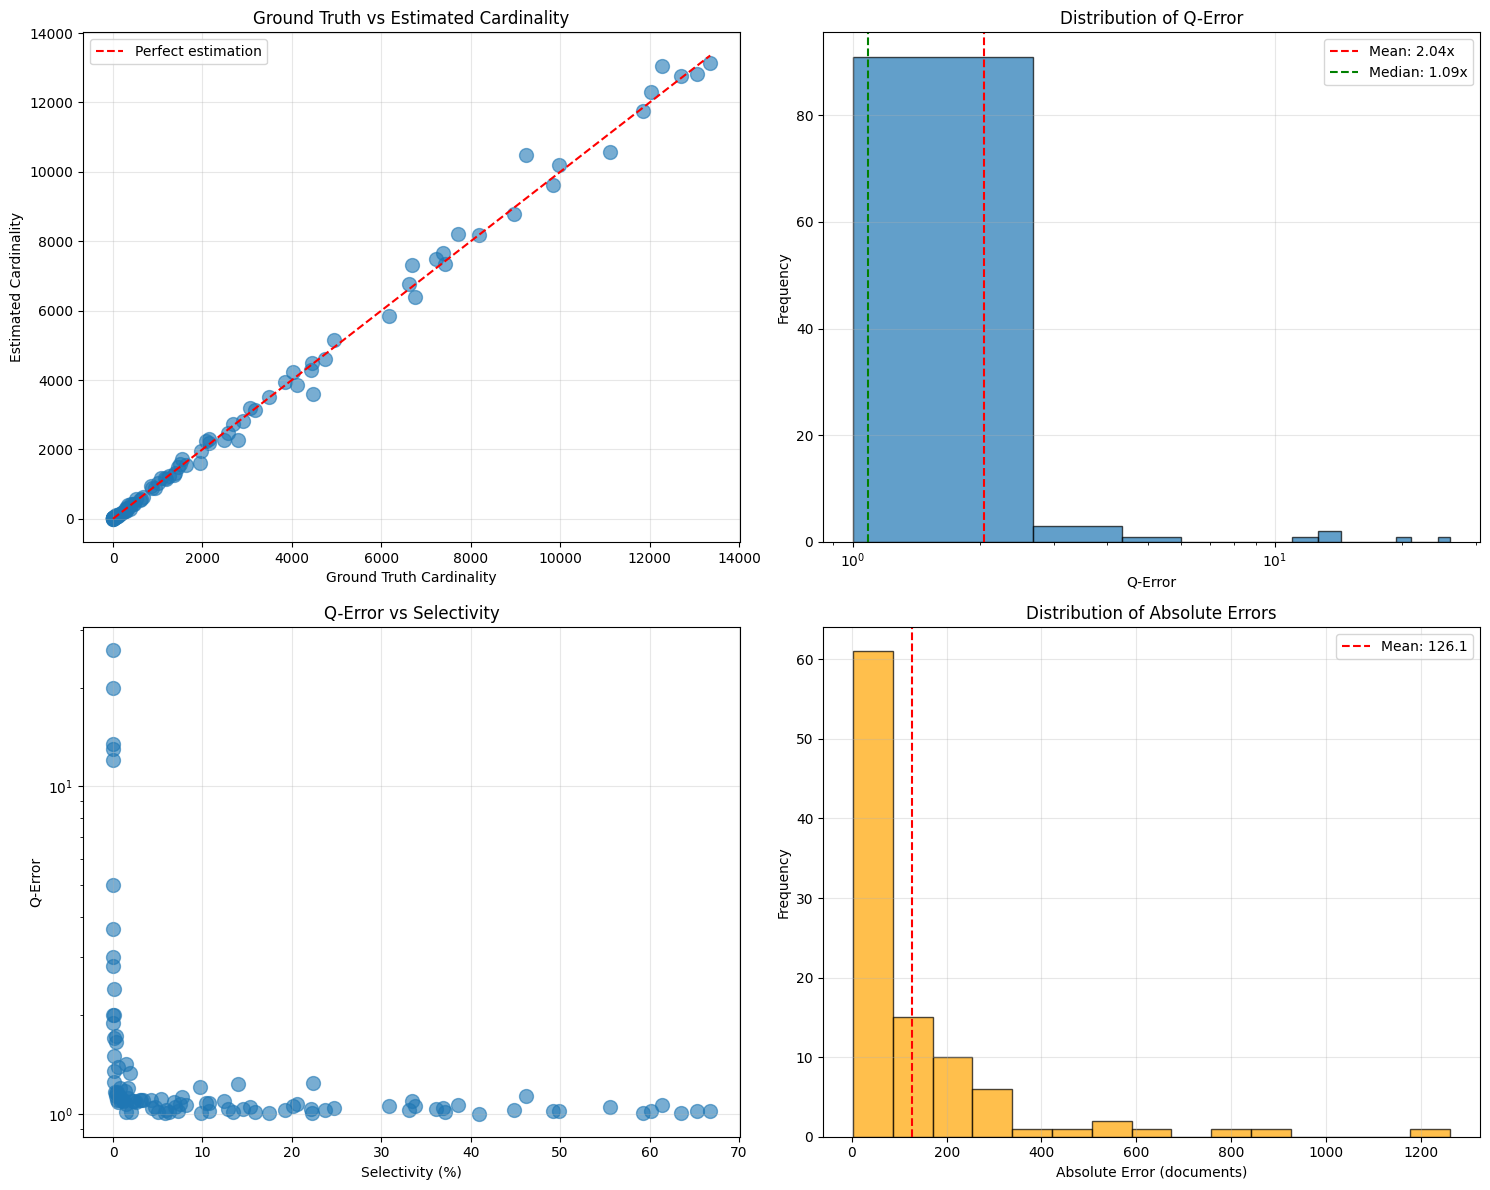

In [14]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Ground truth vs Estimated cardinality
axes[0, 0].scatter(results_df["ground_truth_count"], results_df["estimated_count"], alpha=0.6, s=100)
axes[0, 0].plot(
    [results_df["ground_truth_count"].min(), results_df["ground_truth_count"].max()],
    [results_df["ground_truth_count"].min(), results_df["ground_truth_count"].max()],
    "r--",
    label="Perfect estimation",
)
axes[0, 0].set_xlabel("Ground Truth Cardinality")
axes[0, 0].set_ylabel("Estimated Cardinality")
axes[0, 0].set_title("Ground Truth vs Estimated Cardinality")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Error distribution (with log scale on x-axis)
axes[0, 1].hist(results_df["q_error"], bins=15, edgecolor="black", alpha=0.7)
axes[0, 1].axvline(
    results_df["q_error"].mean(), color="r", linestyle="--", label=f"Mean: {results_df['q_error'].mean():.2f}x"
)
axes[0, 1].axvline(
    results_df["q_error"].median(), color="g", linestyle="--", label=f"Median: {results_df['q_error'].median():.2f}x"
)
axes[0, 1].set_xlabel("Q-Error")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Distribution of Q-Error")
axes[0, 1].set_xscale("log")  # Log scale for Q-Error
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Error vs Selectivity
axes[1, 0].scatter(results_df["ground_truth_selectivity"] * 100, results_df["q_error"], alpha=0.6, s=100)
axes[1, 0].set_xlabel("Selectivity (%)")
axes[1, 0].set_ylabel("Q-Error")
axes[1, 0].set_yscale("log")  # Log scale for Q-Error
axes[1, 0].set_title("Q-Error vs Selectivity")
axes[1, 0].grid(True, alpha=0.3)

# 4. Absolute error distribution
axes[1, 1].hist(results_df["absolute_error"], bins=15, edgecolor="black", alpha=0.7, color="orange")
axes[1, 1].axvline(
    results_df["absolute_error"].mean(),
    color="r",
    linestyle="--",
    label=f"Mean: {results_df['absolute_error'].mean():.1f}",
)
axes[1, 1].set_xlabel("Absolute Error (documents)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Distribution of Absolute Errors")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Using the MCEstimator API

The `MCEstimator` class provides a clean, simple API:

```python
from mdbrtools.query import parse_from_mql
from origami.inference import MCEstimator
from origami.utils import compare_estimate_to_ground_truth

# Create estimator
estimator = MCEstimator(model, pipeline, batch_size=1000)

# Define query (MongoDB query language)
query_dict = {"a": {"$gt": 3, "$lt": 5}}
query = parse_from_mql(query_dict)

# Estimate selectivity (returns probability in [0, 1] and generated samples)
p, samples = estimator.estimate(query, n=1000)

# Convert to cardinality
cardinality = p * NUM_DOCS

# Inspect the generated samples
print(f"First sample: {samples[0]}")
print(f"Number of samples: {len(samples)}")

# Compare to ground truth
result = compare_estimate_to_ground_truth(query, docs, p)
print(f"Estimated: {result['estimated_count']:.1f}, GT: {result['ground_truth_count']}, Q-Error: {result['q_error']:.2f}x")
```

Key features:
- **Simple constructor**: Just `MCEstimator(model, pipeline)`
- **Returns selectivity and samples**: `estimate()` returns `(probability, samples)` tuple
- **Inspect samples**: Access the generated uniform samples for debugging or analysis
- **Complete documents**: Automatically generates full documents with all schema fields
- **Factorial correction**: Automatically applied when `DocPermuterPipe` is detected
- **Ground truth utilities**: Built-in functions to compare estimates with actual data